In [1]:
"""
Getting started with XGBoost
============================

This is a simple example of using the native XGBoost interface, there are other
interfaces in the Python package like scikit-learn interface and Dask interface.


See :doc:`/python/python_intro` and :doc:`/tutorials/index` for other references.

"""
import os
import pickle

import numpy as np
from sklearn.datasets import load_svmlight_file

import matplotlib.pyplot as plt
import xgboost as xgb

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: v0.9.4.4-ds-git20220108-9023143f8b93 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# X is a scipy csr matrix, XGBoost supports many other input types,
X, y = load_svmlight_file("agaricus.txt.train")
dtrain = xgb.DMatrix(X, y)
# validation set
X_test, y_test = load_svmlight_file("agaricus.test.svm")
dtest = xgb.DMatrix(X_test, y_test)

In [3]:
# specify parameters via map, definition are same as c++ version
param = {"max_depth": 2, "eta": 1, "objective": "binary:logistic"}

# specify validations set to watch performance
watchlist = [(dtest, "eval"), (dtrain, "train")]
# number of boosting rounds
num_round = 2
bst = xgb.train(param, dtrain, num_boost_round=num_round, evals=watchlist)

# run prediction
preds = bst.predict(dtest)
labels = dtest.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)
bst.save_model("model-0.json")

[23:36:46] WARNING: ./src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.22669	train-logloss:0.23338
[1]	eval-logloss:0.13787	train-logloss:0.13666
error=0.021726


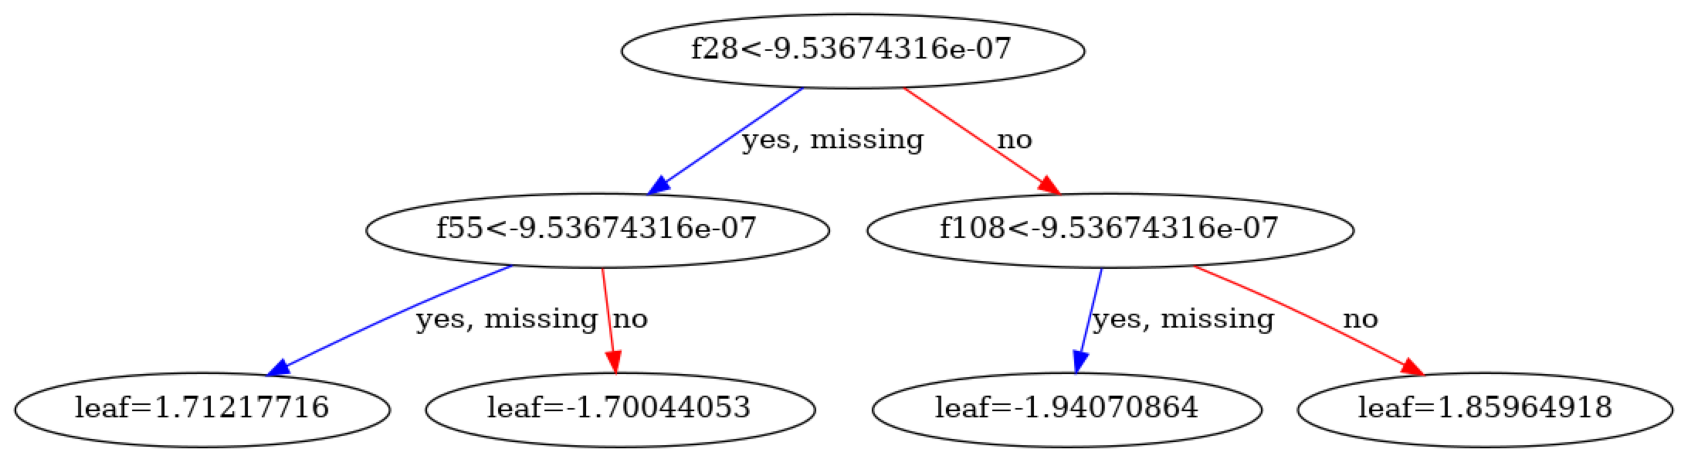

In [4]:
xgb.plot_tree(bst,num_trees=0)
fig = plt.gcf()
fig.set_size_inches(30, 15)

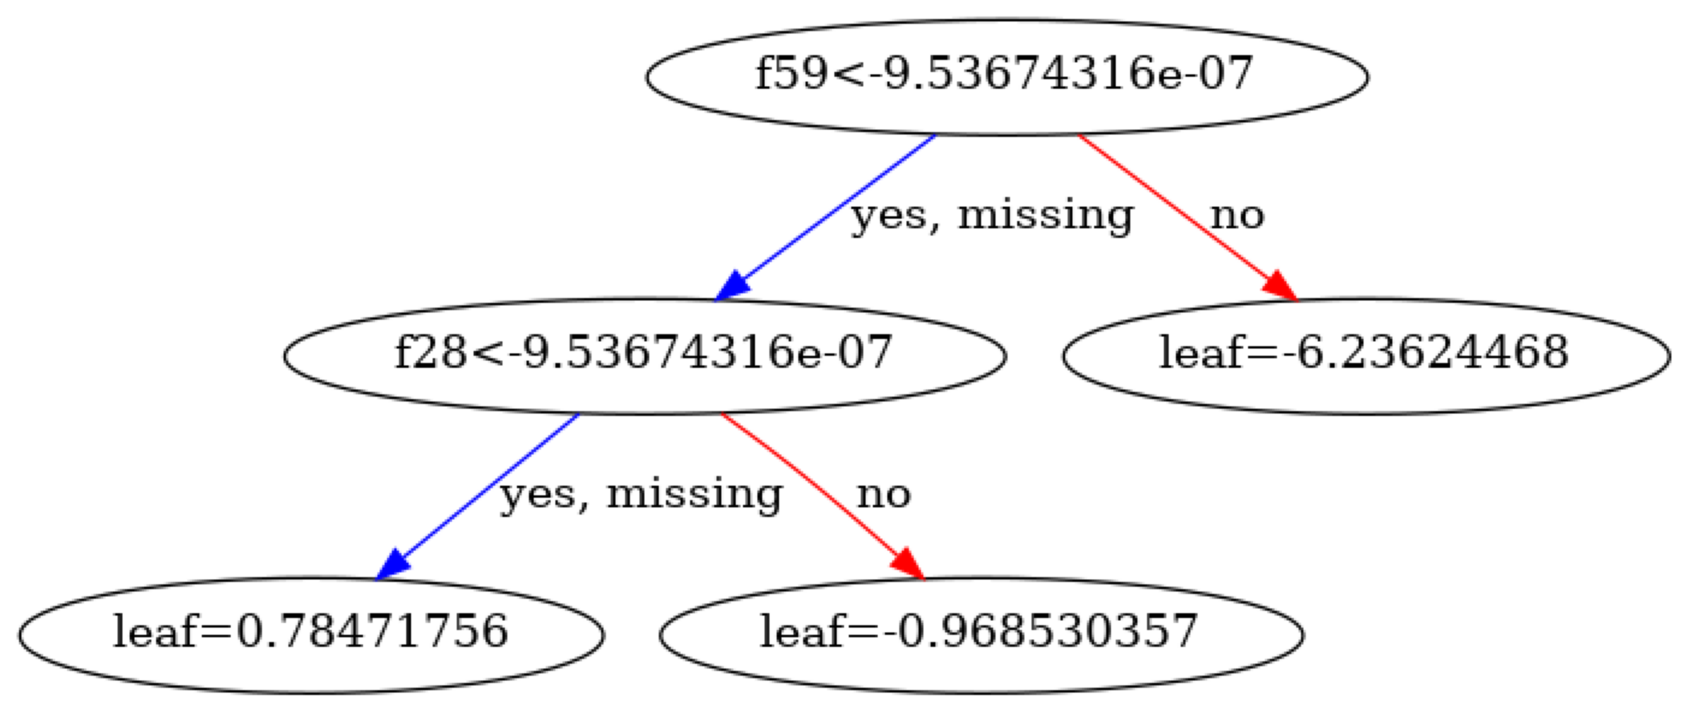

In [5]:
xgb.plot_tree(bst,num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30, 15)

In [6]:
preds[0]

0.28583017

In [7]:
(0.7)/2.

0.35

In [8]:
dtest.num_col()

126

In [9]:
print(X_test[0])

  (0, 0)	1.0
  (0, 8)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 23)	1.0
  (0, 33)	1.0
  (0, 35)	1.0
  (0, 38)	1.0
  (0, 41)	1.0
  (0, 52)	1.0
  (0, 55)	1.0
  (0, 64)	1.0
  (0, 68)	1.0
  (0, 76)	1.0
  (0, 85)	1.0
  (0, 87)	1.0
  (0, 91)	1.0
  (0, 94)	1.0
  (0, 101)	1.0
  (0, 105)	1.0
  (0, 116)	1.0
  (0, 121)	1.0


In [10]:
individual_preds = []
for tree_ in bst:
    individual_preds.append(
        tree_.predict(xgb.DMatrix(X_test),
                      pred_leaf=True,
                      #output_margin=True
                     )
    )
individual_preds

[array([4., 3., 4., ..., 3., 5., 3.], dtype=float32),
 array([3., 3., 3., ..., 3., 4., 3.], dtype=float32)]

In [11]:
print(X_test.getrow(0))

  (0, 0)	1.0
  (0, 8)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 23)	1.0
  (0, 33)	1.0
  (0, 35)	1.0
  (0, 38)	1.0
  (0, 41)	1.0
  (0, 52)	1.0
  (0, 55)	1.0
  (0, 64)	1.0
  (0, 68)	1.0
  (0, 76)	1.0
  (0, 85)	1.0
  (0, 87)	1.0
  (0, 91)	1.0
  (0, 94)	1.0
  (0, 101)	1.0
  (0, 105)	1.0
  (0, 116)	1.0
  (0, 121)	1.0


In [12]:
bst.get_dump()

['0:[f28<-9.53674316e-07] yes=1,no=2,missing=1\n\t1:[f55<-9.53674316e-07] yes=3,no=4,missing=3\n\t\t3:leaf=1.71217716\n\t\t4:leaf=-1.70044053\n\t2:[f108<-9.53674316e-07] yes=5,no=6,missing=5\n\t\t5:leaf=-1.94070864\n\t\t6:leaf=1.85964918\n',
 '0:[f59<-9.53674316e-07] yes=1,no=2,missing=1\n\t1:[f28<-9.53674316e-07] yes=3,no=4,missing=3\n\t\t3:leaf=0.78471756\n\t\t4:leaf=-0.968530357\n\t2:leaf=-6.23624468\n']

In [13]:
preds

array([0.28583017, 0.9239239 , 0.28583017, ..., 0.9239239 , 0.05169873,
       0.9239239 ], dtype=float32)

In [18]:
with open('logistic.t', 'w', encoding="utf-8") as f:
    f.write('  $ ../bin/parse_xgboost.exe model-0.json agaricus.test.svm\n')
    for i in preds:
      f.write(f'  {i:0.2f}\n')